In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from os import listdir
from matplotlib import image

from sklearn.model_selection import train_test_split

In [78]:
moneda = 'DCR-USD'
#Ventana de tiempo: 1 para diario, 7 para semanal, 30 para mensual
window_MA = 30

loaded_images = pd.DataFrame(columns = ['IMG','Cluster'])
img = []
label = []
for filename in listdir('/home/sacbe/Bitmoney/test/IMG/'+str(moneda)+'_'+str(window_MA)):
    img_data = image.imread('/home/sacbe/Bitmoney/test/IMG/'+str(moneda)+'_'+str(window_MA)+'/'+filename)
    img.append(img_data)
    label.append(filename[-5])

loaded_images['IMG'] = img
loaded_images['Cluster'] = label

In [79]:
train, test = train_test_split(loaded_images, test_size=0.2)

train_img0 = np.asarray(train['IMG'])
test_img0 = np.asarray(test['IMG'])

train_img = np.arange(1024).reshape((32, 32))
test_img = np.arange(1024).reshape((32, 32))

for array in train_img0:
    train_img = np.concatenate([train_img, array])

for array in test_img0:
    test_img = np.concatenate([test_img, array])

train_img = np.delete(train_img, np.arange(32), axis=0)
test_img = np.delete(test_img, np.arange(32), axis=0)

train_img = train_img.reshape(-1,32,32,1)
test_img = test_img.reshape(-1,32,32,1)

In [80]:
s = pd.Series(np.arange(len(train)))
train = train.set_index(s)
j = 0

#En BTC los clusters (5,1,6) son vender (3,8,0,7) incertidumbre (2,4,9) compra
#En ETH los clusters (6,2,5) son vender (8,0,7,3) incertidumbre (9,1,4) compra
#En DCR los clusters (3,6,0) son vender (7,4,8,2) incertidumbre (9,1,5) compra

for i in train['Cluster']:
    if(i == '3' or i == '6' or i == '0'):
        train['Cluster'][j] = 2 #Vende
    elif(i == '7' or i == '4' or i == '8' or i == '2'):
        train['Cluster'][j] = 1 #Incertidumbre
    else:
        train['Cluster'][j] = 0 #Compra
    j = j + 1
        

s = pd.Series(np.arange(len(test)))
test = test.set_index(s)

j = 0
for i in test['Cluster']:
    if(i == '3' or i == '6' or i == '0'):
        test['Cluster'][j] = 2 #Vende
    elif(i == '7' or i == '4' or i == '8' or i == '2'):
        test['Cluster'][j] = 1 #Incertidumbre
    else:
        test['Cluster'][j] = 0 #Compra
    j += 1


    
train_cluster = np.asarray(train['Cluster']).astype('uint8').reshape(-1,1)
test_cluster = np.asarray(test['Cluster']).astype('uint8').reshape(-1,1)

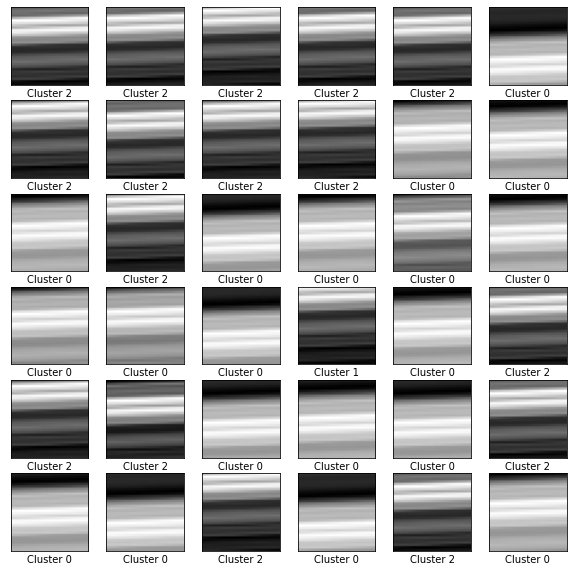

In [73]:
class_names = ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7','Cluster 8','Cluster 9']
#class_names = ['Cluster 0', 'Cluster 1', 'Cluster 2']

plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_img[i].reshape(32,32), cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_cluster[i][0]])
plt.show()

In [81]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

In [82]:
model.add(layers.Flatten())
model.add(layers.Dense(2560, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 12, 12, 128)       36992     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 2, 2, 256)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024)             

In [83]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_img, train_cluster, epochs=50,
                    validation_data=(test_img, test_cluster))

Epoch 1/50
6/6 [==============================] - 2s 379ms/step - loss: 0.9039 - accuracy: 0.6591 - val_loss: 0.2621 - val_accuracy: 0.9318
Epoch 2/50
6/6 [==============================] - 1s 232ms/step - loss: 0.3382 - accuracy: 0.8750 - val_loss: 0.2207 - val_accuracy: 0.9318
Epoch 3/50
6/6 [==============================] - 2s 263ms/step - loss: 0.3359 - accuracy: 0.8636 - val_loss: 0.4449 - val_accuracy: 0.7273
Epoch 4/50
6/6 [==============================] - 2s 264ms/step - loss: 0.4325 - accuracy: 0.7841 - val_loss: 0.1940 - val_accuracy: 0.9318
Epoch 5/50
6/6 [==============================] - 1s 239ms/step - loss: 0.3423 - accuracy: 0.8523 - val_loss: 0.1844 - val_accuracy: 0.9318
Epoch 6/50
6/6 [==============================] - 2s 255ms/step - loss: 0.3161 - accuracy: 0.8523 - val_loss: 0.1680 - val_accuracy: 0.9318
Epoch 7/50
6/6 [==============================] - 1s 244ms/step - loss: 0.3294 - accuracy: 0.8466 - val_loss: 0.1442 - val_accuracy: 0.9091
Epoch 8/50
6/6 [====

2/2 - 0s - loss: 0.1064 - accuracy: 0.9318


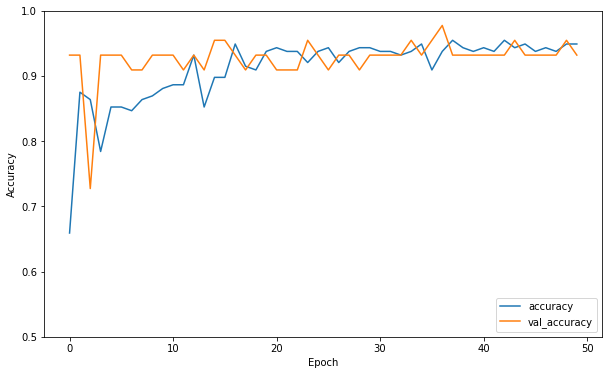

In [84]:
#print(test_acc)
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
#plt.savefig('Acurracy'+str(moneda)+'_'+str(window_MA)+'.png', dpi = 100)
test_loss, test_acc = model.evaluate(test_img,  test_cluster, verbose=2)
model.save('CNN_'+str(moneda)+'_'+str(window_MA)+'.h5')